# Matthew McCabe - 300581425

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl

from pandas.plotting import scatter_matrix

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict

from sklearn.model_selection import GridSearchCV

### Load Training Data

In [2]:
train = pd.read_csv('train.csv').drop("Loan_ID", axis=1)  # "Loan_ID" just has the id of the application, not relevant
train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,Yes,0,Graduate,No,1025,5500.0,216.0,360.0,NaN,Rural,Y
1,Male,Yes,3+,Graduate,Yes,5677,1424.0,100.0,360.0,1.0,Rural,Y
2,Male,No,0,Graduate,Yes,7085,0.0,84.0,360.0,1.0,Semiurban,Y
3,Male,Yes,1,Graduate,Yes,2895,0.0,95.0,360.0,1.0,Semiurban,Y
4,Male,Yes,2,Not Graduate,No,6125,1625.0,187.0,480.0,1.0,Semiurban,N


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             481 non-null    object 
 1   Married            488 non-null    object 
 2   Dependents         478 non-null    object 
 3   Education          491 non-null    object 
 4   Self_Employed      465 non-null    object 
 5   ApplicantIncome    491 non-null    int64  
 6   CoapplicantIncome  491 non-null    float64
 7   LoanAmount         473 non-null    float64
 8   Loan_Amount_Term   480 non-null    float64
 9   Credit_History     452 non-null    float64
 10  Property_Area      491 non-null    object 
 11  Loan_Status        491 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 46.2+ KB


### Explore Training Data

In [4]:
for label in train.columns:
    print("##", label, "##")
    print(train[label].value_counts())

## Gender ##
Male      394
Female     87
Name: Gender, dtype: int64
## Married ##
Yes    315
No     173
Name: Married, dtype: int64
## Dependents ##
0     280
2      81
1      75
3+     42
Name: Dependents, dtype: int64
## Education ##
Graduate        384
Not Graduate    107
Name: Education, dtype: int64
## Self_Employed ##
No     404
Yes     61
Name: Self_Employed, dtype: int64
## ApplicantIncome ##
2500    8
4583    6
6000    5
2600    5
4166    5
       ..
3073    1
5488    1
2130    1
3357    1
4095    1
Name: ApplicantIncome, Length: 412, dtype: int64
## CoapplicantIncome ##
0.0       222
2083.0      5
1666.0      3
1800.0      3
5625.0      3
         ... 
1964.0      1
1843.0      1
1030.0      1
3334.0      1
1993.0      1
Name: CoapplicantIncome, Length: 232, dtype: int64
## LoanAmount ##
110.0    15
120.0    13
100.0    13
187.0    12
160.0    12
         ..
153.0     1
242.0     1
324.0     1
240.0     1
35.0      1
Name: LoanAmount, Length: 184, dtype: int64
## Loan_Amount_

In [5]:
numerical = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

nominal = ['Property_Area', 'Gender', 'Married', 'Education', 'Self_Employed', 'Credit_History']

ordinal = ['Dependents']
order = [['0', '1', '2', '3+']]

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
0,1025,5500.0,216.0,360.0
1,5677,1424.0,100.0,360.0
2,7085,0.0,84.0,360.0
3,2895,0.0,95.0,360.0
4,6125,1625.0,187.0,480.0


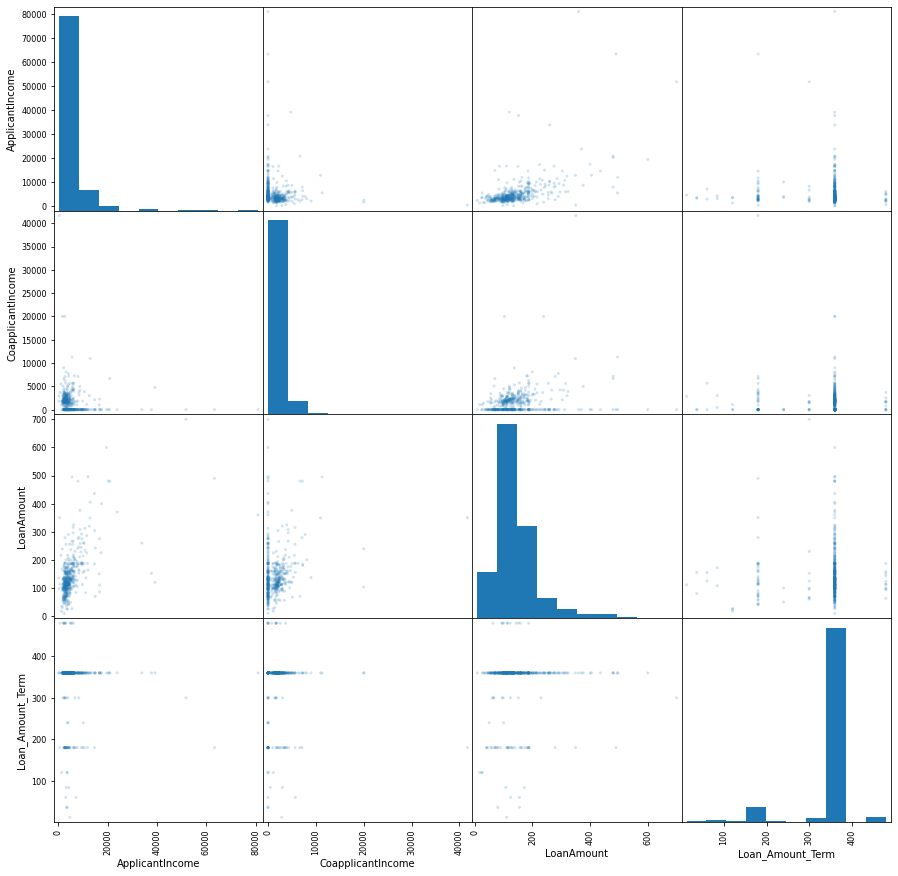

In [6]:
train_numerical = train[numerical]
scatter_matrix(train_numerical, figsize=(15, 15), alpha=0.2)
train_numerical.head()

As there is some clumping for the plots of smaller values in some columns (see 'LoanAmount', 'ApplicantIncome', and 'CoapplicantIncome'), we can take the log of each numerical column and plot those to get a cleaner spread.

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
0,6.933423,8.612685,5.379897,5.888878
1,8.644354,7.261927,4.615121,5.888878
2,8.865876,0.000000,4.442651,5.888878
3,7.971086,0.000000,4.564348,5.888878
4,8.720297,7.393878,5.236442,6.175867


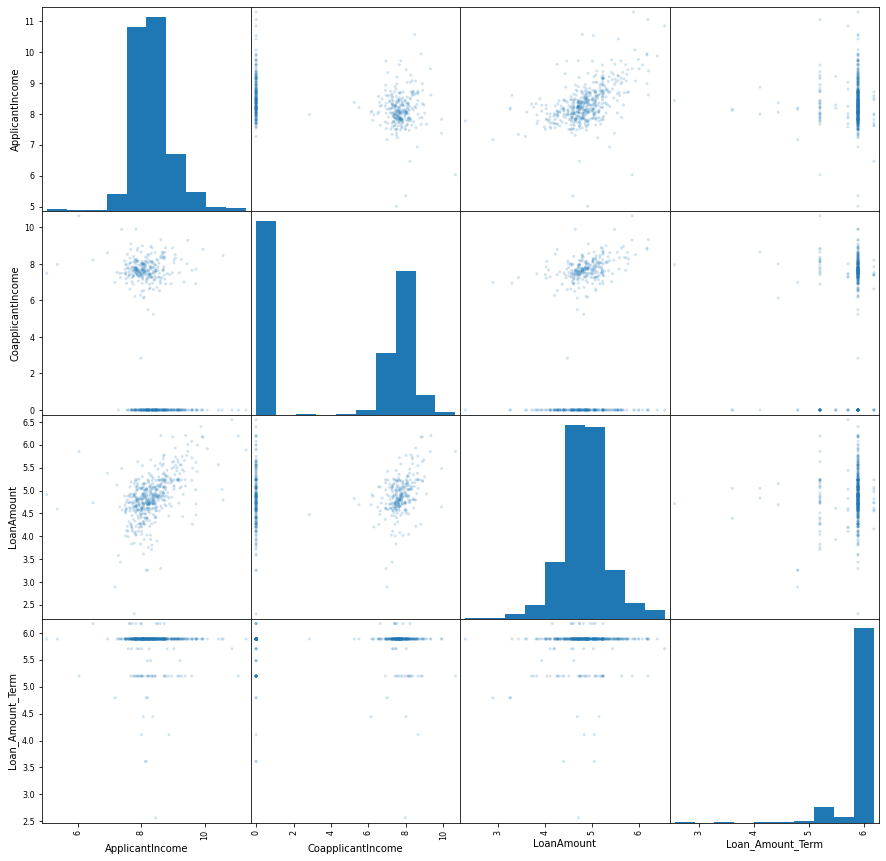

In [7]:
train_numerical_log = np.zeros(np.shape(train_numerical))
for i in range(len(numerical)):
    for j in range(len(train_numerical[numerical[i]])):
        a = np.log1p(train_numerical[numerical[i]].loc[j])
        train_numerical_log[j][i] = a
train_numerical_log = pd.DataFrame(train_numerical_log, columns=train_numerical.columns)
scatter_matrix(train_numerical_log, figsize=(15, 15), alpha=0.2)
train_numerical_log.head()

With the log applied to the data, it is easier to observe the spread. Unfortunately, there are few insights to be drawn from this data, as it is difficult to spot any major correlation between any two columns.

Triangles for approved applications, 'X's for denied applications


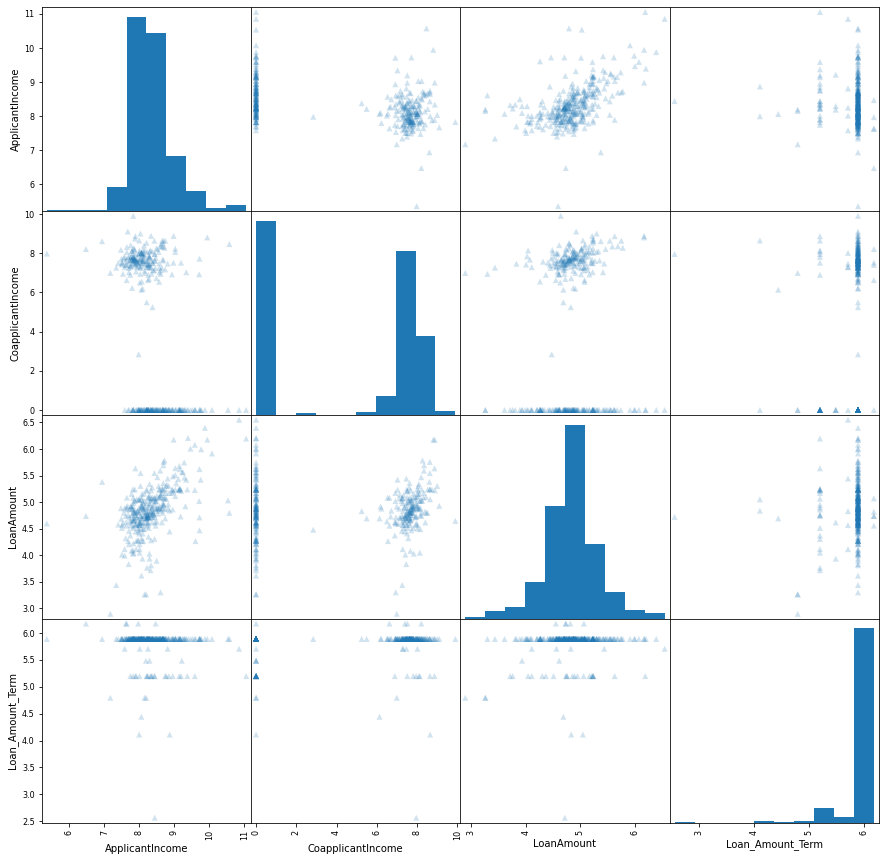

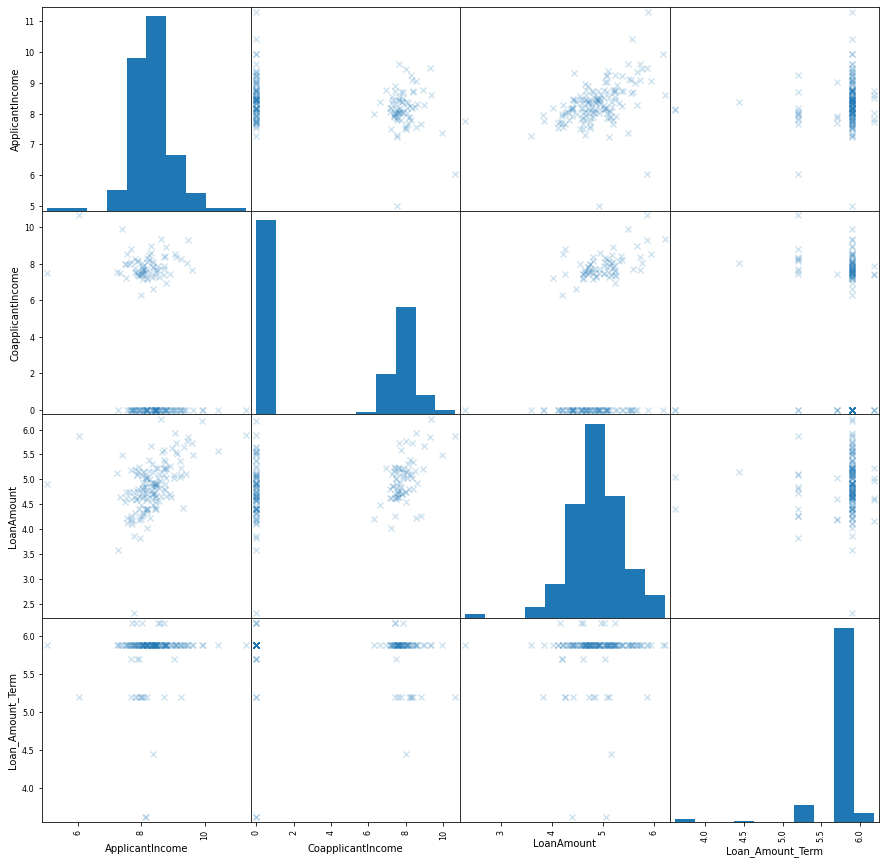

In [8]:
trainY = np.squeeze(np.where(train['Loan_Status'] == 'Y'))
trainN = np.squeeze(np.where(train['Loan_Status'] == 'N'))

scatter_matrix(train_numerical_log.iloc[trainY], figsize=(15, 15), alpha=0.2, marker = '^')
scatter_matrix(train_numerical_log.iloc[trainN], figsize=(15, 15), alpha=0.2, marker = 'x')
print("Triangles for approved applications, 'X's for denied applications")

In [9]:
train.corr()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
ApplicantIncome,1.000000,-0.110785,0.555682,-0.042544,-0.005591
CoapplicantIncome,-0.110785,1.000000,0.231470,-0.083123,-0.016492
LoanAmount,0.555682,0.231470,1.000000,0.046584,0.007391
Loan_Amount_Term,-0.042544,-0.083123,0.046584,1.000000,-0.011873
Credit_History,-0.005591,-0.016492,0.007391,-0.011873,1.000000


The numerical data columns aren't very closely correlated, meaning each column contains unique information. This makes analysing components manually very difficult, and also means that dimensionality reduction also isn't likely to help.

### Rework Training Data

In [10]:
numerical_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                               ('scaler', StandardScaler())])

nominal_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                             ('encoder', OneHotEncoder(handle_unknown='ignore'))])

ordinal_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                             ('encoder', OrdinalEncoder(categories=order)),
                             ('scaler', StandardScaler())])

preprocessor = ColumnTransformer([
    ('numerical_transformer', numerical_pipeline, numerical),
    ('nominal_transformer', nominal_pipeline, nominal),
    ('ordinal_transformer', ordinal_pipeline, ordinal),
])

In [11]:
## I believe that knowing these values is important,
## so we would drop all applicants that are missing any of these datapoints ##
dropColumns = ['Self_Employed', 'Education', 'Credit_History']

## If any entries are missing 2 or more data points, drop them indiscriminately
def drop(t):
    tD = t.dropna(thresh=2).dropna(subset=dropColumns)
    return tD

preprocessor.fit(drop(train))

def x_y_split(t):           
    tD = drop(t)
    X_t = preprocessor.transform(tD)
    y_t = tD['Loan_Status'].apply(lambda i: {'Y':1, 'N':0}[i])
    return X_t, y_t

In [12]:
X_train, y_train = x_y_split(train)
print("X_train shape:", np.shape(X_train))
print("y_train shape:", np.shape(y_train))

X_train shape: (431, 18)
y_train shape: (431,)


### Load and Scale Test Data

In [13]:
test = pd.read_csv('test.csv').drop("Loan_ID", axis=1)  # "Loan_ID" just has the id of the application, not relevant
test.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,Yes,3+,Graduate,No,5703,0.0,128.0,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,8080,2250.0,180.0,360.0,1.0,Urban,Y
2,Female,No,0,Graduate,No,7200,0.0,120.0,360.0,1.0,Rural,Y
3,Male,Yes,2,Not Graduate,No,3917,0.0,124.0,360.0,1.0,Semiurban,Y
4,Male,Yes,NaN,Graduate,Yes,5503,4490.0,70.0,NaN,1.0,Semiurban,Y


In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             120 non-null    object 
 1   Married            123 non-null    object 
 2   Dependents         121 non-null    object 
 3   Education          123 non-null    object 
 4   Self_Employed      117 non-null    object 
 5   ApplicantIncome    123 non-null    int64  
 6   CoapplicantIncome  123 non-null    float64
 7   LoanAmount         119 non-null    float64
 8   Loan_Amount_Term   120 non-null    float64
 9   Credit_History     112 non-null    float64
 10  Property_Area      123 non-null    object 
 11  Loan_Status        123 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 11.7+ KB


In [15]:
X_test, y_test = x_y_split(test)
print("X_test shape:", np.shape(X_test))
print("y_test shape:", np.shape(y_test))

X_test shape: (107, 18)
y_test shape: (107,)


## Modelling

In [16]:
def plot_precision_vs_recall(precisions, recalls, label=None):
    pl.figure(figsize=(6, 6))
    pl.plot(recalls, precisions, "b-", linewidth=2)
    pl.title(label, fontsize=18)
    pl.xlabel("Recall", fontsize=14)
    pl.ylabel("Precision", fontsize=14)
    pl.axis([0, 1, 0, 1])
    pl.grid(True)
    pl.show()
    
def plot_roc_curve(y, scores, label=None):
    fpr, tpr, thresholds = roc_curve(y, scores)
    print(f"ROC Score: {roc_auc_score(y, scores)*100:.4f}%")
    pl.figure(figsize=(6, 6))
    pl.plot(fpr, tpr, "b-", linewidth=2)
    pl.plot([0, 1], [0, 1], 'k--')
    pl.axis([0, 1, 0, 1])
    pl.title(label, fontsize=18)
    pl.xlabel('False Positive Rate (1 - Specificity)', fontsize=14)
    pl.ylabel('True Positive Rate (Sensitivity)', fontsize=14)
    pl.grid(True)  
    pl.show()

def model_accuracy(model, x, y):
    p = model.predict(x)
    print(f"Accuracy: {accuracy_score(y, p)*100:.4f}%")
    cm = confusion_matrix(y, p)
    print(f"Precision: {(cm[1,1]/(cm[1,1]+cm[0,1]))*100:.4f}%")
    print(f"Recall/Sensitivity: {(cm[1,1]/(cm[1,1]+cm[1,0]))*100:.4f}%")
    print(f"Specificity: {(cm[0,0]/(cm[0,0]+cm[0,1]))*100:.4f}%")    

def make_precision_vs_recall(model, x, y, label=None):
    model_accuracy(model, x, y)
    scores = cross_val_predict(model, x, y, cv=3, method="decision_function")
    precisions, recalls, thresholds = precision_recall_curve(y, scores)
    plot_precision_vs_recall(precisions, recalls, label)
    plot_roc_curve(y, scores, label)

### Logistic Regression (Linear Model to serve as a baseline)

In [17]:
from sklearn.linear_model import LogisticRegression

linear_model = LogisticRegression()
linear_model.fit(X_train, y_train)

LogisticRegression()

Accuracy: 80.9745%
Precision: 78.8301%
Recall/Sensitivity: 97.9239%
Specificity: 46.4789%


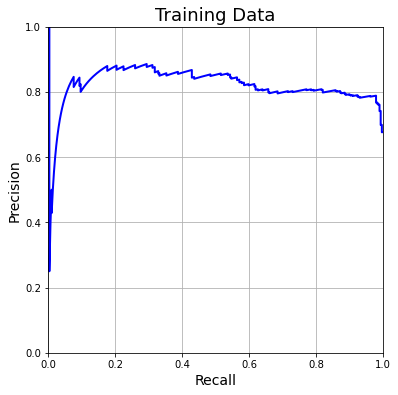

ROC Score: 76.7313%


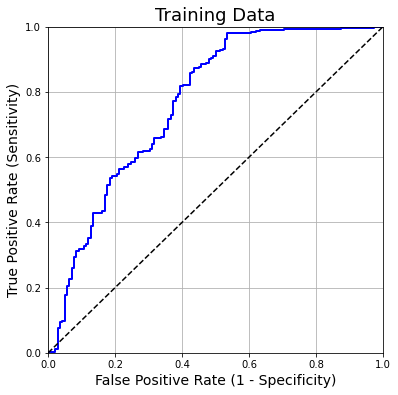

In [18]:
make_precision_vs_recall(linear_model, X_train, y_train, label="Training Data")

Accuracy: 81.3084%
Precision: 80.0000%
Recall/Sensitivity: 97.2973%
Specificity: 45.4545%


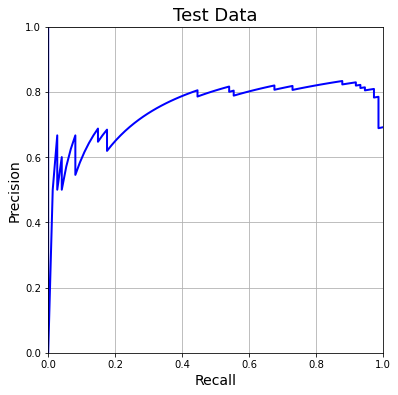

ROC Score: 69.9836%


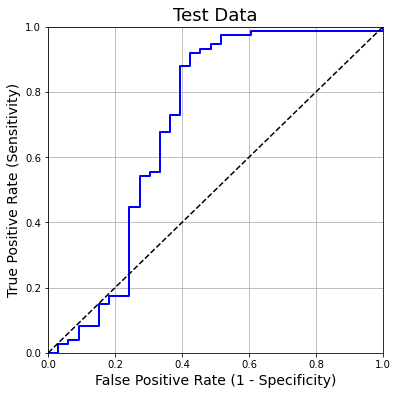

In [19]:
make_precision_vs_recall(linear_model, X_test, y_test, label="Test Data")

### SGDClassifier

In [20]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(random_state=0)
sgd.fit(X_train, y_train)

SGDClassifier(random_state=0)

Accuracy: 64.5012%
Precision: 81.1927%
Recall/Sensitivity: 61.2457%
Specificity: 71.1268%


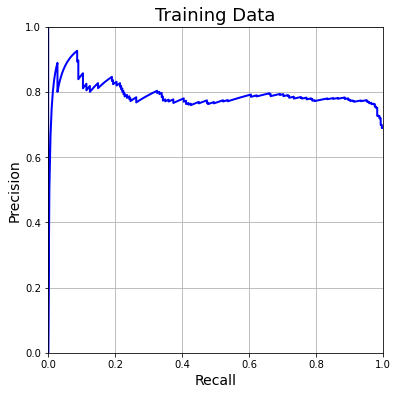

ROC Score: 70.9903%


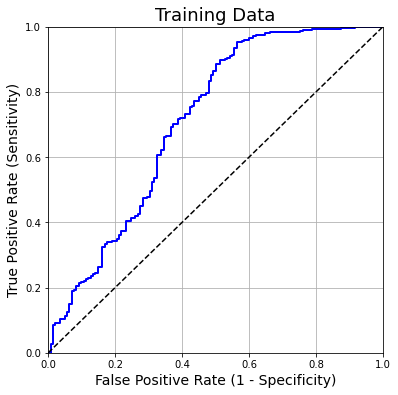

In [21]:
make_precision_vs_recall(sgd, X_train, y_train, label="Training Data")

Accuracy: 69.1589%
Precision: 90.1961%
Recall/Sensitivity: 62.1622%
Specificity: 84.8485%


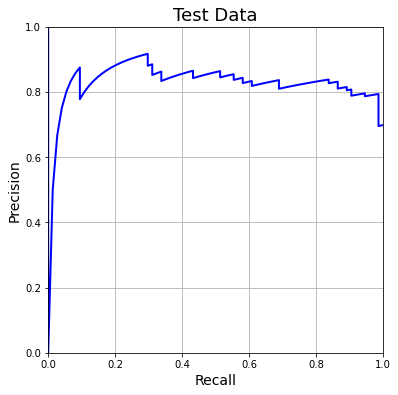

ROC Score: 76.2080%


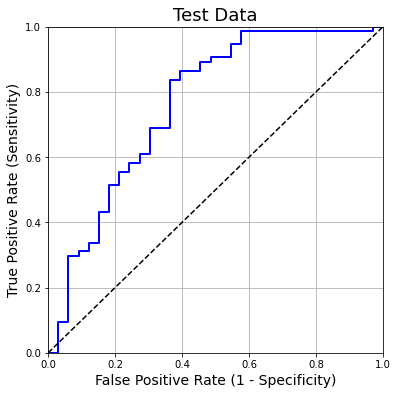

In [22]:
make_precision_vs_recall(sgd, X_test, y_test, label="Test Data")

### Grid Search for the SGDClassifier

In [23]:
alpha = 0.1**np.arange(7)
param_grid = [{'alpha': alpha,
               'penalty' : ['l1', 'l2', 'none']},
             {'alpha': alpha,
               'penalty' : ['elasticnet'],
              'l1_ratio' : [0.01, 0.05, 0.15, 0.25, 0.35, 0.5, 0.65, 0.75, 0.85, 0.95, 0.99]}]

grid_search = GridSearchCV(sgd, param_grid, cv=5,
                           scoring='roc_auc',  ## ROC (AUC) is the evaluation metric ##
                           return_train_score=True)

In [24]:
grid_search.fit(X_train, y_train)
score = np.around(grid_search.best_score_, decimals=3)
print(grid_search.best_params_, "Score:", score)
grid_sgd = grid_search.best_estimator_

{'alpha': 0.0010000000000000002, 'l1_ratio': 0.85, 'penalty': 'elasticnet'} Score: 0.781


Accuracy: 80.7425%
Precision: 78.7709%
Recall/Sensitivity: 97.5779%
Specificity: 46.4789%


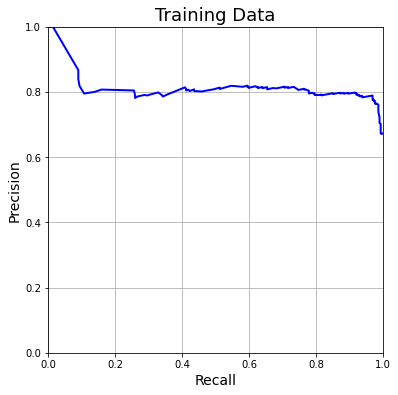

ROC Score: 74.2799%


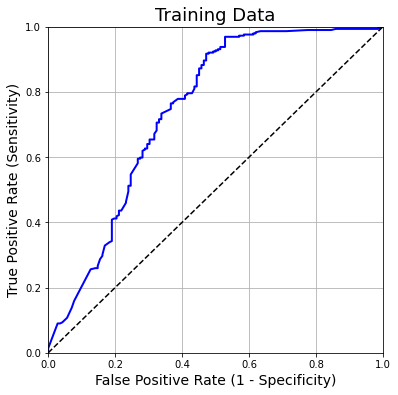

In [25]:
make_precision_vs_recall(grid_sgd, X_train, y_train, label="Training Data")

Accuracy: 82.2430%
Precision: 80.2198%
Recall/Sensitivity: 98.6486%
Specificity: 45.4545%


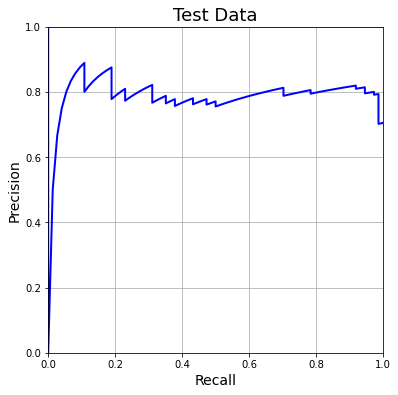

ROC Score: 70.5569%


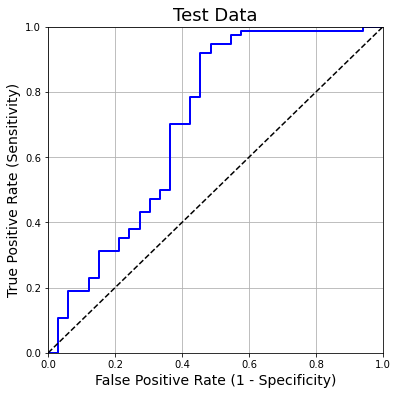

In [26]:
make_precision_vs_recall(grid_sgd, X_test, y_test, label="Test Data")

## Conclusion

Decision trees weren't good for this assignment as the ROC curve would just be composed of two straight lines. I chose the SGD Classifier because it allowed penalties to be applied to the model, and because classifier has the advantage of being capable of handling very large datasets efficiently. Unfortunately, the SGD Classifier is not much more accurate than the Logistic Regression.

Further steps may include further experimentation with the column transformer (changing how `nan` values in columns are treated/dropped), exploring more prediction models (i.e. SVC, voting classifiers, perhaps even kNearestNeighbours), and maybe implementing AdaBoost training to correct any incorrect predictions.